In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.feature_selection import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore
import os
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import spearmanr, pearsonr
from scipy.stats import chi2_contingency
from sklearn.preprocessing import KBinsDiscretizer
import itertools
from sklearn.metrics import precision_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

In [3]:
# Lade die bereinigten Parquet-Dateien
df_damage = pd.read_parquet("transformed_damage_first.parquet")
df_label = pd.read_parquet("transformed_label_first.parquet")

In [5]:
df_label.head(10)

,label,cash_desk,total_amount,n_lines,payment_medium,has_feedback,feedback_categorical,feedback_low,feedback_middle,feedback_high,...,has_long_shelf_life,has_convenience,has_fruits_vegetables_pieces,has_missing,mean_time_between_scans,max_time_between_scans,time_to_first_scan,time_from_last_scan_to_end,days_since_sco_introduction,transaction_id
0,NORMAL,2,13.12,3,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,9.387875,10.583388,9.058792,15.873231,0,94d35a72-85cc-4a69-b80c-92a996fc8b73
1,NORMAL,1,11.52,4,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,False,False,3.359838,4.729999,2.521944,7.609351,0,de96bde5-7b1a-4290-a811-abda2a714f05
2,NORMAL,2,7.92,2,CREDIT_CARD,False,MISSING,False,False,False,...,True,False,True,False,11.349666,11.349666,2.777601,10.821077,0,ffb2a18f-f939-48fd-a15a-5b4dea7dbfaf
3,NORMAL,1,209.17,21,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,7.644550,15.232503,7.469778,6.994438,0,f5ab96be-eea1-4c5d-b8ad-b685fa0cfa4a
4,NORMAL,1,130.68,4,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,7.904591,9.409289,6.085485,8.007759,0,32f74844-795e-4a71-8b89-8a6af735e164
5,NORMAL,1,97.76,5,CREDIT_CARD,False,MISSING,False,False,False,...,False,True,True,False,3.134099,6.108651,4.825217,12.681974,0,786a2585-8230-487c-a39a-bfae7ce5c047
6,NORMAL,3,146.61,13,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,4.339333,10.758632,0.706293,12.097396,0,5b169f28-da93-4503-9229-5d753b7c018f
7,NORMAL,1,19.69,2,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,1.060722,1.060722,10.068779,11.692407,0,0b36017e-c169-4e8d-b045-d1072faef2f1
8,NORMAL,2,41.56,4,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,5.047066,9.193132,4.432973,17.949444,0,fa965c1c-4422-4022-9399-ce61ced995b9
9,NORMAL,1,48.47,6,CREDIT_CARD,False,MISSING,False,False,False,...,False,False,True,False,9.155678,14.329252,5.139536,9.649522,0,0ea5f363-2b65-4717-828c-4b2b9b04bf57


In [15]:
df_label.columns

Index(['label', 'cash_desk', 'total_amount', 'n_lines', 'payment_medium',
       'has_feedback', 'feedback_categorical', 'feedback_low',
       'feedback_middle', 'feedback_high', 'feedback_top', 'daytime', 'hour',
       'hour_categorical', 'day_of_week', 'month',
       'transaction_duration_seconds', 'store_id', 'location', 'urbanization',
       'has_voided', 'n_voided', 'has_unscanned', 'n_age_restricted',
       'has_age_restricted', 'popularity_max', 'popularity_min',
       'max_product_price', 'n_sold_by_weight', 'has_sold_by_weight',
       'has_camera_detected_wrong_product',
       'has_camera_detected_wrong_product_high_certainty',
       'calculated_price_difference', 'has_positive_price_difference',
       'has_bakery', 'has_frozen_goods', 'has_personal_care',
       'has_fruits_vegetables', 'has_household', 'has_snacks',
       'has_limited_time_offers', 'has_dairy', 'has_beverages', 'has_tobacco',
       'has_alcohol', 'has_long_shelf_life', 'has_convenience',
       '

In [19]:
#discretionize features for rule learning
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_discrete = df_label.copy()
num_cols = df_label.select_dtypes(include=["float64", "int64"]).columns
df_discrete[num_cols] = discretizer.fit_transform(df_label[num_cols])


C:\Users\49152\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [27]:
df_pre = df_label.copy()
df_pre["label"] = df_label["label"].map({"NORMAL": 0, "FRAUD": 1})

#list of columns
all_cols = df_pre.columns.tolist()

#only discrete columns with 10 or less many different values (e.g. remove transaction hash)
cat_cols = [
    col for col in df_pre.select_dtypes(include=["object", "category"]).columns
    if df_pre[col].nunique() <= 10 and col != "label"
]

#combine with numierical features
num_cols = df_pre.select_dtypes(include=["int64", "float64"]).columns.tolist()

# encoding
df_bin = pd.get_dummies(df_pre[cat_cols + num_cols + ["label"]], drop_first=True)


In [33]:
print("Number of feautures:", df_bin.shape[1] - 1) 
print("Columns remained:", df_bin.columns[:39])


Number of feautures: 39
Columns remained: Index(['label', 'total_amount', 'n_lines', 'transaction_duration_seconds',
       'popularity_max', 'popularity_min', 'max_product_price',
       'calculated_price_difference', 'mean_time_between_scans',
       'max_time_between_scans', 'time_to_first_scan',
       'time_from_last_scan_to_end', 'days_since_sco_introduction', 'label',
       'cash_desk_1', 'cash_desk_2', 'cash_desk_3', 'payment_medium_CASH',
       'feedback_categorical_TOP', 'feedback_categorical_HIGH',
       'feedback_categorical_MIDDLE', 'feedback_categorical_LOW',
       'daytime_noon', 'daytime_afternoon', 'daytime_evening',
       'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday',
       'day_of_week_Monday', 'day_of_week_Tuesday',
       'store_id_6a7406ec-4ebb-4df7-83ce-9528663e553e',
       'store_id_46e6da32-f4b0-40f3-ada7-fc6ca81ed85d',
       'store_id_3fffea06-686f-42bd-8362-818af86b48a9',
       'store_id_581831fc-6a03-4e38-9025-0a889b7fe542', '

In [45]:
#First: Only consider rules of two binary columns
binary_cols = [col for col in df_label.columns 
               if df_label[col].nunique() == 2 and col != "label"]

#transform NORMAL / FRAUD into 0/1
y = df_label["label"].map({"NORMAL": 0, "FRAUD": 1})

#save results
results = []

# All combinations of two binary features
for feat1, feat2 in itertools.combinations(binary_cols, 2):
    #Rule: Both features need to be 1
    rule_mask = (df_label[feat1] == 1) & (df_label[feat2] == 1)
    
    if rule_mask.sum() == 0:
        continue

    y_pred = rule_mask.astype(int)  #if rule is true, then predict 1 (FRAUD), otherwise 0 (NORMAL)
    precision = precision_score(y, y_pred)

    results.append({
        "feature_1": feat1,
        "feature_2": feat2,
        "matches": rule_mask.sum(),
        "frauds_captured": y[rule_mask].sum(),
        "precision": precision
    })

#As data frame sorted for precision
df_rules = pd.DataFrame(results).sort_values(by="precision", ascending=False)

df_rules.to_csv("fraud_rules_two_features.csv", index=False)




In [47]:
df_rules.head(100)

,feature_1,feature_2,matches,frauds_captured,precision
304,has_fruits_vegetables_pieces,has_missing,13,13.0,1.000000
262,has_fruits_vegetables,has_missing,1,1.0,1.000000
132,has_unscanned,has_dairy,133,133.0,1.000000
131,has_unscanned,has_snacks,11,11.0,1.000000
130,has_unscanned,has_household,14,14.0,1.000000
...,...,...,...,...,...
260,has_fruits_vegetables,has_convenience,1192,57.0,0.047819
266,has_household,has_tobacco,171,8.0,0.046784
167,has_sold_by_weight,has_beverages,1569,73.0,0.046526
256,has_fruits_vegetables,has_beverages,1569,73.0,0.046526


In [59]:
#Since unscanned is part of most of the relevant rules, we consider rules with one feature separately

df = df_label.copy()
df["label_binary"] = df["label"].map({"NORMAL": 0, "FRAUD": 1})

#Only consider features with less or equal to 20 different values
categorical = df.select_dtypes(include=["bool", "object", "category"])
categorical = categorical.loc[:, categorical.nunique() <= 20]

#Rule generation
rules = []
total_frauds = df["label_binary"].sum()

for feature in categorical.columns:
    grouped = df.groupby(feature)["label_binary"].agg(["count", "sum"]).reset_index()
    grouped["precision"] = grouped["sum"] / grouped["count"]
    grouped["recall"] = grouped["sum"] / total_frauds
    grouped["feature"] = feature
    grouped.rename(columns={feature: "value", "count": "support", "sum": "fraud_hits"}, inplace=True)
    rules.append(grouped)

#sort
df_rules_single = pd.concat(rules, ignore_index=True)
df_rules_single = df_rules_single.sort_values("precision", ascending=False)

#show
from IPython.display import display
display(df_rules_single.head(20))

#save results
df_rules_single.to_csv("rule_results_single_feature.csv", index=False)


KeyboardInterrupt: 

In [67]:
#show top rules
df_rules_single.head(20)

,value,support,fraud_hits,precision,recall,feature
116,True,16,16.0,1.000000,0.003437,has_missing
2,FRAUD,4655,4655.0,1.000000,1.000000,label
77,True,377,377.0,1.000000,0.080988,has_unscanned
87,True,11114,2713.0,0.244107,0.582814,has_positive_price_difference
8,CASH,14688,2909.0,0.198053,0.624919,payment_medium
99,True,3360,404.0,0.120238,0.086788,has_snacks
85,True,17626,1054.0,0.059798,0.226423,has_camera_detected_wrong_product_high_certainty
41,21,8974,460.0,0.051259,0.098818,hour_categorical
27,evening,19111,920.0,0.048140,0.197637,daytime
40,20,10136,460.0,0.045383,0.098818,hour_categorical


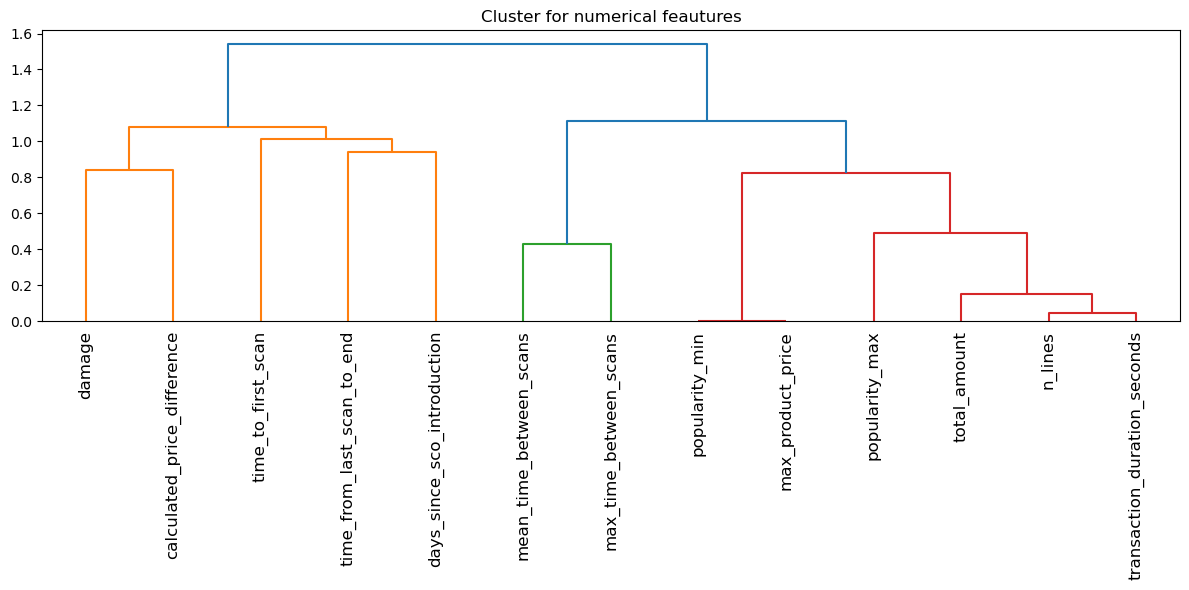

In [79]:
#correlation analysis
numerical = df_damage.select_dtypes(include=["float64", "int64"])

#correlation matrix
corr = numerical.corr(method="spearman").abs()  # Spearman = monotone Beziehungen
distance = 1 - corr
linkage_matrix = linkage(squareform(distance), method='ward')

#Dendogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=corr.columns, leaf_rotation=90)
plt.title("Cluster for numerical feautures")
plt.tight_layout()
plt.savefig("eda_plots/dendrogram_feature_clustering.png")
plt.show()


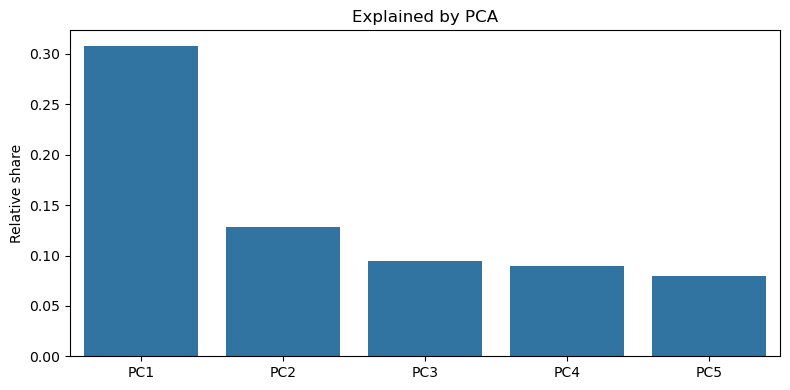

In [77]:
#standardize data
X_scaled = StandardScaler().fit_transform(numerical.dropna())

#Principal Component ANalyis
pca = PCA(n_components=5)
components = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=[f"PC{i+1}" for i in range(5)], y=explained_var)
plt.title("Explained by PCA")
plt.ylabel("Relative share")
plt.tight_layout()
plt.savefig("eda_plots/pca_explained_variance.png")
plt.show()


,Regel,TP,FP,FN,TN,Precision,Recall,FPR,FNR,Verhinderter Schaden
0,has_unscanned == True,377,0,4278,143369,1.0,0.080988,0.0,0.919012,5088.38
1,has_missing == True,16,0,4639,143369,1.0,0.003437,0.0,0.996563,200.07


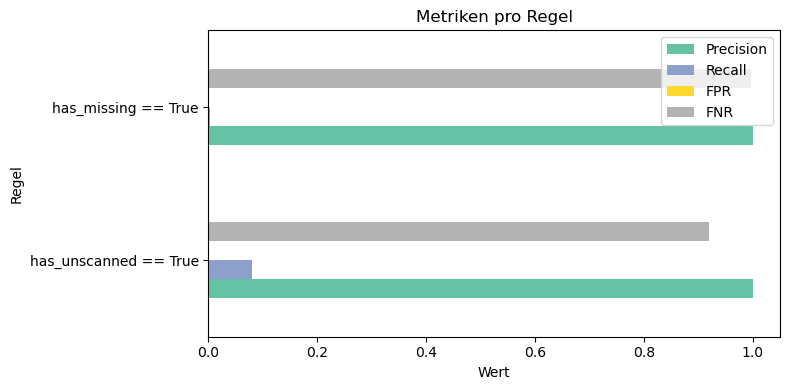

KeyError: "None of [Index(['Prevented Damage'], dtype='object')] are in the [columns]"

In [91]:
df_label["label_binary"] = df_label["label"].map({"NORMAL": 0, "FRAUD": 1})

#merge with damage
df_merged = df_label.merge(df_damage[["damage"]], left_index=True, right_index=True, how="left")

#define rule
rules = {
    "has_unscanned == True": df_merged["has_unscanned"] == True,
    "has_missing == True": df_merged["has_missing"] == True
}

os.makedirs("rule_plots", exist_ok=True)

results = []

for rule_name, mask in rules.items():
    tp = ((df_merged["label_binary"] == 1) & mask).sum()
    fp = ((df_merged["label_binary"] == 0) & mask).sum()
    fn = ((df_merged["label_binary"] == 1) & (~mask)).sum()
    tn = ((df_merged["label_binary"] == 0) & (~mask)).sum()

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    fnr = fn / (tp + fn) if (tp + fn) else 0

    damage_prevented = df_merged.loc[mask & (df_merged["label_binary"] == 1), "damage"].sum()

    results.append({
        "Regel": rule_name,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "Precision": precision,
        "Recall": recall,
        "FPR": fpr,
        "FNR": fnr,
        "Verhinderter Schaden": damage_prevented
    })

    #confusion plot
    plt.figure(figsize=(5, 4))
    sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred NORMAL", "Pred FRAUD"],
                yticklabels=["True NORMAL", "True FRAUD"])
    plt.title(f"Confusion Matrix: {rule_name}")
    plt.tight_layout()
    plt.savefig(f"rule_plots/confusion_{rule_name.replace(' ', '_').replace('==', '_eq_')}.png")
    plt.close()

#put in df
df_results = pd.DataFrame(results)
display(df_results)

#plot accuracy and recall
df_results.set_index("Regel")[["Precision", "Recall", "FPR", "FNR"]].plot.barh(figsize=(8, 4), colormap="Set2")
plt.title("Metriken pro Regel")
plt.xlabel("Wert")
plt.tight_layout()
plt.savefig("rule_plots/metrics_summary_barplot.png")
plt.show()

#plot prevented damage
df_results.set_index("Regel")[["Prevented Damage"]].plot.barh(figsize=(8, 3), color="darkred")
plt.title("Verhinderter Schaden durch Regel")
plt.xlabel("EUR")
plt.tight_layout()
plt.savefig("rule_plots/prevented_damage.png")
plt.show()

#save as csv
df_results.to_csv("rule_plots/rule_evaluation_summary.csv", index=False)
